[本文參考](https://trevormcguire.medium.com/attention-transformers-and-gpt-b3adbbb4a950)

In [5]:
%pip install matplotlib

  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-win_amd64.whl.metadata (167 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl (218 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl (55 kB)
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

sentence = "The New York Rangers beat the Pittsburgh Penguins last night"

words = sentence.lower().split()

int2word = {k: v for (k, v) in enumerate(set(words))}
word2int = {v: k for (k, v) in int2word.items()}

vocab_size = len(word2int)

embedding_dim = 3
embedding_layer = np.random.randn(vocab_size, embedding_dim)

tokens = [word2int[w] for w in words]

embeddings = np.asarray([embedding_layer[idx] for idx in tokens])

print(sentence)
print(tokens)
print(embeddings)

The New York Rangers beat the Pittsburgh Penguins last night
[2, 4, 0, 3, 8, 2, 1, 5, 6, 7]
[[ 1.57921282  0.76743473 -0.46947439]
 [ 0.24196227 -1.91328024 -1.72491783]
 [ 0.49671415 -0.1382643   0.64768854]
 [ 0.54256004 -0.46341769 -0.46572975]
 [-0.54438272  0.11092259 -1.15099358]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 1.52302986 -0.23415337 -0.23413696]
 [-0.56228753 -1.01283112  0.31424733]
 [-0.90802408 -1.4123037   1.46564877]
 [-0.2257763   0.0675282  -1.42474819]]


Now that we have our word embeddings, we can calculate our query, keys, and values (Q, K, V). To do so, we’ll create three distinct weight matrices. Each one of these weight matrices are multiplied to our embeddings, resulting in Q, K, and V.


In [11]:

# weights to calculate (Q, K, V)
w_q = np.random.random((embedding_dim, 3))
w_k = np.random.random((embedding_dim, 3))
w_v = np.random.random((embedding_dim, 3))

# calculate (Q, K, V), each as a seperate linear transform of the same input
Q = embeddings @ w_q
K = embeddings @ w_k
V = embeddings @ w_v

print("Embeddings")
print(embeddings)
print("Query")
print(Q)
print("Keys")
print(K)
print("Values")
print(V)

Embeddings
[[ 1.57921282  0.76743473 -0.46947439]
 [ 0.24196227 -1.91328024 -1.72491783]
 [ 0.49671415 -0.1382643   0.64768854]
 [ 0.54256004 -0.46341769 -0.46572975]
 [-0.54438272  0.11092259 -1.15099358]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 1.52302986 -0.23415337 -0.23413696]
 [-0.56228753 -1.01283112  0.31424733]
 [-0.90802408 -1.4123037   1.46564877]
 [-0.2257763   0.0675282  -1.42474819]]
Query
[[ 1.0236411   1.21446683  0.99348173]
 [-1.15496633 -1.56255307 -1.15822032]
 [ 0.14088637  1.0116738   0.73135858]
 [-0.1012697   0.04011379  0.0449029 ]
 [-0.20434229 -1.49720963 -1.07306106]
 [ 1.0236411   1.21446683  0.99348173]
 [ 0.41665836  1.20863014  0.93757875]
 [-0.79868656 -0.42040179 -0.38068838]
 [-1.10044886  0.18589282 -0.00395628]
 [-0.12689047 -1.43819599 -1.01117038]]
Keys
[[ 1.67093896  0.05262976  1.42487316]
 [-1.73772692 -0.92607642 -1.01836225]
 [ 0.35540157  0.1779199   0.79650677]
 [-0.0870137  -0.22892804  0.19757874]
 [-0.5042232  -0.33783351 -1.11182495]
 

Step 2: Calculate Attention Scores
After obtaining the query, keys, and values, the next step is to calculate something called the “attention scores”. These scores represent the relevance of each word in the input sequence. Specifically, the attention scores measure the similarity between the query and each key in the sequence, resulting in a weight for each word.

This is done in three steps:

Take the dot product of Q and K.
Divide the result by the square root of the dimensionality of K (which has the same dimensionality as Q and V, since they’re generated from the same input). This is done to help keep gradients stable during training.
Then, we pass the result through a softmax operation to produce a probability distribution.


In [12]:

def softmax(x: np.ndarray, axis: int) -> np.ndarray:
    x = np.exp(x - np.amax(x, axis=axis, keepdims=True))
    return x / np.sum(x, axis=axis, keepdims=True)

# calculate attention scores as dot product between Q and K
scores = Q @ K.T  # (n x n) matrix
print(scores.shape)

# divide by dimensionality of K, and pass through softmax operation
scores = softmax(scores / K.shape[1]**0.5, axis=1)
print("Attention Scores:")
print(scores)

(10, 10)
Attention Scores:
[[0.30850022 0.00510159 0.10794998 0.04431808 0.01514096 0.30850022
  0.16018936 0.01603457 0.01732338 0.01694163]
 [0.00390566 0.46970841 0.01276633 0.03694237 0.12920595 0.00390566
  0.00833193 0.11697628 0.10373475 0.11452267]
 [0.18868635 0.02877519 0.13990061 0.08263329 0.04311927 0.18868635
  0.15473341 0.05800644 0.07113212 0.04432695]
 [0.09373507 0.10497937 0.09988313 0.09997483 0.09877492 0.09373507
  0.09778751 0.10474648 0.10820454 0.09817909]
 [0.01962094 0.31057087 0.03034983 0.06587284 0.17110963 0.01962094
  0.02624796 0.11046363 0.08169368 0.16444968]
 [0.30850022 0.00510159 0.10794998 0.04431808 0.01514096 0.30850022
  0.16018936 0.01603457 0.01732338 0.01694163]
 [0.23980641 0.01421582 0.1357283  0.06642825 0.0274117  0.23980641
  0.167268   0.0361634  0.04410068 0.02907104]
 [0.0239536  0.25025489 0.04893244 0.07555315 0.1253925  0.0239536
  0.03727827 0.14464367 0.15405075 0.11598713]
 [0.02626294 0.20734341 0.06148911 0.07807338 0.100889

These scores can also be visualized with a heatmap.


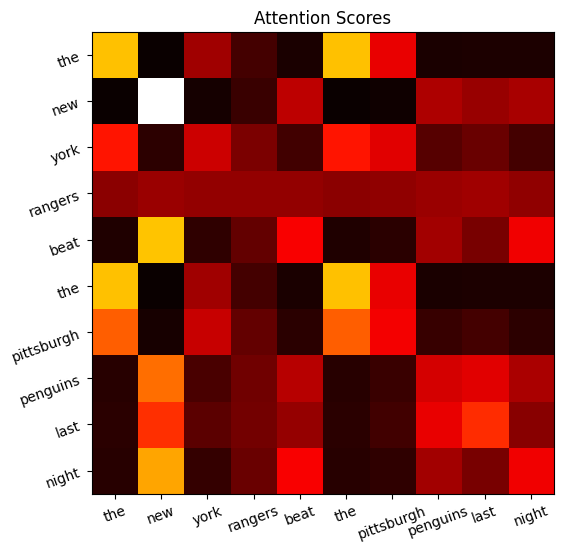

In [13]:

labels = [int2word.get(x) for x in tokens]
ticks = list(range(len(tokens)))

plt.figure(figsize=(15,6))
plt.imshow(scores, cmap="hot")
plt.xticks(ticks, labels, rotation=20)
plt.yticks(ticks, labels, rotation=20)
plt.title("Attention Scores")
plt.show()

Step 3: Apply Attention Scores to Values
Lastly, we multiply the values by the attention scores. The intuition here is to keep intact the values of the words we want to focus on, and drown-out irrelevant words (by multiplying them by tiny numbers).


In [14]:

# multiple attention scores with our valuese (V)
# this tells us how much to "attend" to our values
attention_output = scores @ V
attention_output

array([[ 0.45783325,  0.23632164,  0.84101772],
       [-0.63295085, -1.10860515, -0.66867597],
       [ 0.26188861,  0.07833135,  0.45896106],
       [-0.05903711, -0.27580924,  0.00195395],
       [-0.51538426, -0.91150469, -0.48686928],
       [ 0.45783325,  0.23632164,  0.84101772],
       [ 0.36571715,  0.16860832,  0.64689475],
       [-0.37143404, -0.65691128, -0.4417543 ],
       [-0.28153034, -0.49298919, -0.41459087],
       [-0.48636806, -0.86825784, -0.45163411]])

Let’s pause for a second and think about what we’re doing here.

We took a sentence, broke it apart, and calculated which parts to focus on. This is where the name Attention comes from — we are determining which words to pay attention to.

Take this sentence, for example:

The dog didn’t chase the ball because it was tired.

What does “it” refer to here? The dog or the ball? As humans, it’s pretty obvious that “it” is referring to the dog. But how do we teach that to an algorithm? It turns out that self-attention is a pretty remarkable way of doing this.

As the model processes each word, self-attention allows it to look at other words in the input sequence for clues about what a word truly means.

Of course, self-attention isn’t the only mechanism capable of doing this. Recurrent models (RNNs, LSTMs, GRUs, …etc.), for example, can do this by maintaining a hidden state and iterating over each word.

Self-attention, however, does it in a (generally) more efficient way — so efficient, in fact, that one might say Attention Is All You Need.

Multi-Head Attention
Hopefully you’re still with me up until this point, as there is one more “trick” we need to discuss. In the Transformer architecture, self-attention is actually used in a slightly different way.

Instead of calculating self-attention for the entire input sequence, the query, keys, and values are projected into a number of smaller parts. These parts are called “feature heads”.

Each one of these feature heads consist of a smaller Q, K, and V, which all get treated as they would in regular self-attention. The only difference here is that the dimensionality is smaller. This is because we project our input sequence into smaller pieces, where the number of pieces is equal to the number of heads.

After each piece is passed through the attention mechanism, the results are concatenated back together. This entire process is called Multi-Head Attention, and is the standard way that Transformer-based architectures compute attention.

Let’s see what this looks like in code:


In [15]:

def attention(q: np.ndarray, k: np.ndarray, v: np.ndarray) -> np.ndarray:
    scores = np.dot(q, k.T)
    scores = softmax(scores / k.shape[1]**0.5, axis=1)
    return np.dot(scores, v)

num_heads = 2

# split each of Q, K, V into 'num_heads' chunks
# in reality, Q, K, V are projected 'num_heads' times,
# with each having a dimensionality of d_K / num_heads
Q_heads = np.array_split(Q, num_heads)
K_heads = np.array_split(K, num_heads)
V_heads = np.array_split(V, num_heads)

mha = []  # multi_headed_attention
for q, k, v in zip(Q_heads, K_heads, V_heads):
    mha.append(attention(q, k, v))

mha = np.concatenate(mha)

print(f"Multi-Head Attention With {num_heads} Heads:")
print(mha)

Multi-Head Attention With 2 Heads:
[[ 0.44150481  0.25630446  0.80619129]
 [-0.81997286 -1.53600257 -0.73102764]
 [ 0.23639842  0.04032013  0.47314202]
 [-0.14986566 -0.47994775  0.01504484]
 [-0.66741524 -1.24909657 -0.55101313]
 [ 0.47296681  0.2178011   0.87329564]
 [ 0.38332672  0.16845373  0.65991626]
 [-0.15783958 -0.1643486  -0.4271538 ]
 [-0.09804599 -0.04975283 -0.44695114]
 [-0.27382263 -0.39982791 -0.36192074]]


So, why do we do this? Well, in the words of the authors of Attention Is All You Need:

“Due to the reduced dimension of each head, the total computational cost [of multi-head attention] is similar to that of single-head attention with full dimensionality.”

What this means is that by projecting our input sequence into smaller components, we can calculate a richer representation of the same input for essentially the same cost.

Transformers
So, how exactly is self-attention used in Transformers? What does this looks like?

The transformer architecture is typically composed of an encoder-decoder structure, followed by a task-specific classification or regression layer. In Attention Is All You Need, this looks like the below:


Let’s break this down piece-by-piece.

On the left, we have our Encoder. And on the right, we have our Decoder. If you’re not familiar with this type of architecture, I would recommend this quick blog post.

Both the Encoder and Decoder are comrpised of only a few basic building blocks: Multi-Head Attention, “Add & Norm”, and a feed-forward neural network. Since we already discussed Multi-Head Attention, we can briefly focus on the other two.

First, let’s tackle “Add & Norm”. As its name suggests, this consists of two different operations: addition and layer normalization. Layer normalization is similar to batch normalization, except it occurs over the feature dimension.

To understand the purpose of the addition operation, take another look at the diagram. Did you notice how there is an arrow connecting each sub-layer’s input to its output? This is called a residual connection, and is a popular trick in the AI world. To be clear, a residual connection is when a layer’s input is added back to its output. By doing this, we are providing the model another way to route information.

So, using what we know so far, we can begin to piece together what is happening here:

First, our input undergoes three seperate linear transformations to create our query, keys, and values (Q, K, V).
Then, the query, keys, and values are projected into smaller pieces. Each one of these pieces is used to calculate self-attention seperately, and the results are concatenated back together.
Lastly, we add back the original input and normalize
For clarity’s sake, let’s write some code demonstrating everything we’ve talked about up until this point:


In [16]:

sentence = "The New York Rangers beat the Pittsburgh Penguins last night"

words = sentence.lower().split()

int2word = {k: v for (k, v) in enumerate(set(words))}
word2int = {v: k for (k, v) in int2word.items()}

vocab_size = len(word2int)

embedding_dim = 3
embedding_layer = np.random.randn(vocab_size, embedding_dim)

tokens = [word2int[w] for w in words]

embeddings = np.asarray([embedding_layer[idx] for idx in tokens])



In [17]:

def attention(q: np.ndarray, k: np.ndarray, v: np.ndarray) -> np.ndarray:
    scores = np.dot(q, k.T)
    scores = softmax(scores / k.shape[1]**0.5, axis=1)
    return np.dot(scores, v)

def multi_headed_attention(q: np.ndarray,
                           k: np.ndarray,
                           v: np.ndarray,
                           num_heads: int) -> np.ndarray:
    q_heads = np.array_split(Q, num_heads)
    k_heads = np.array_split(K, num_heads)
    v_heads = np.array_split(V, num_heads)
    mha = []  # multi_headed_attention
    for query, keys, values in zip(q_heads, k_heads, v_heads):
        mha.append(attention(query, keys, values))
    mha = np.concatenate(mha)
    return mha

# weights to calculate (Q, K, V)
w_q = np.random.random((embedding_dim, 3))
w_k = np.random.random((embedding_dim, 3))
w_v = np.random.random((embedding_dim, 3))

# calculate (Q, K, V), each as a seperate linear transform of the same input
Q = embeddings @ w_q
K = embeddings @ w_k
V = embeddings @ w_v

mha_output = multi_headed_attention(Q, K, V, num_heads=3)

# add back the original input embeddings
mha_output = mha_output + embeddings

print(f"MHA Input (shape={embeddings.shape}):")
print(embeddings)
print(f"MHA Output (shape={mha_output.shape}):")
print(mha_output)

MHA Input (shape=(10, 3)):
[[ 0.291034   -0.63555974 -1.02155219]
 [-0.22945045  0.38934891 -1.26511911]
 [ 2.55948803  0.39423302  0.12221917]
 [-0.16175539 -0.5336488  -0.00552786]
 [-1.3466781  -0.88059127 -1.1305523 ]
 [ 0.291034   -0.63555974 -1.02155219]
 [-0.51543566 -0.60025385  0.94743982]
 [ 1.09199226  2.77831304  1.19363972]
 [ 0.21863832  0.88176104 -1.00908534]
 [-1.58329421  0.77370042 -0.53814166]]
MHA Output (shape=(10, 3)):
[[-0.4531963  -1.2675409  -1.41577522]
 [-1.01337236 -0.27155402 -1.673251  ]
 [ 3.81316406  2.51879144  1.85267536]
 [-0.71675577 -0.94089902 -0.23904459]
 [-3.29811619 -3.03701076 -2.64934546]
 [-1.24570005 -2.24369986 -2.11663954]
 [-1.54497729 -1.55793042  0.35114916]
 [ 4.7618882   5.79372129  2.89120891]
 [ 0.61735195  0.59496485 -1.51766408]
 [-1.7164068  -0.22265905 -1.57963478]]


To continue, the Feed-Forward Neural Network is comprised of two linear transformations with a non-linear transformation in between. The non-linear activation function used is the Rectified Linear Unit (ReLU).

In Attention Is All You Need, the initial layer expands the data by a degree of four, while the output layer compresses the data back to its original dimension. While this is not a set-in-stone rule, this is also what we’ll be doing.

The below code takes the output of our Multi-Head Attention operation, and passes it through the feed-forward net. Then, it adds back the feed-forward net’s input (which is attention’s output).

Note that we are leaving out the layer normalization and bias terms to keep things simple.


In [18]:

def relu(a):
    return np.maximum(0, a)

ffn_input_shape = mha_output.shape[-1]
ffn_weights_1 = np.random.randn(ffn_input_shape, ffn_input_shape*4)
ffn_weights_2 = np.random.randn(ffn_input_shape*4, ffn_input_shape)

ffn_out = relu(np.dot(mha_output, ffn_weights_1))
ffn_out = np.dot(ffn_out, ffn_weights_2)

ffn_out = ffn_out + mha_output

print(f"FFN Input Shape: {mha_output.shape}")
print(f"FFN Output Shape: {ffn_out.shape}")

FFN Input Shape: (10, 3)
FFN Output Shape: (10, 3)
